In [1]:
cd ..

/home/vule/projects/learn_agent


<img src="/home/vule/projects/learn_agent/images/basic_reflection_with_tool.png" width="700"/>

In [15]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, SystemMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from src.key import openai_api_key, tavily_api_key
from typing import Annotated, TypedDict
import operator
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver


llm = ChatOpenAI(model="gpt-4o-mini", api_key=openai_api_key)

tavily_tool = TavilySearchResults(max_results=3)

In [16]:
# try tavily_tool

search_result = tavily_tool.invoke("importance of reflection in artificial intelligence")


In [23]:
def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])

search_result = run_queries(['importance of reflection in artificial intelligence', 'examples of reflection in AI', 'role of reflection in machine learning'])

search_result


[[{'url': 'https://www.semanticscholar.org/paper/Reflective-Artificial-Intelligence-Lewis-Sarkadi/3d222012bd85ca7a33e726e107ba55c910ead827',
   'content': "This paper asks what reflective AI might look like, drawing on notions of reflection in complex systems, cognitive science, and agents, and sketches an architecture for reflective AI agents, and highlights ways forward. As artificial intelligence (AI) technology advances, we increasingly delegate mental tasks to machines. However, today's AI systems usually do these tasks with an unusual"},
  {'url': 'https://deepai.org/publication/reflective-artificial-intelligence',
   'content': "Peter R. Lewis\nStefan Sarkadi\npage 1\npage 2\npage 3\npage 4\nRelated Research\nMaking AI 'Smart': Bridging AI and Cognitive Science\nDigital Normativity: A challenge for human subjectivization and free\nwill\nBuilding Human-like Communicative Intelligence: A Grounded Perspective\nExperience, Imitation and Reflection; Confucius' Conjecture and Machine\

**Initial responder**



In [3]:
from pydantic import BaseModel, Field
from pydantic import ValidationError
from langchain_core.messages import ToolMessage

# define the output of model
class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous.")

print(Reflection.model_json_schema())

class AnswerQuestion(BaseModel):
    answer: str = Field(description="~250 words detailed answer to the question.")
    reflection: Reflection = Field(description="The reflection on the inital answer.")
    search_query: list[str] = Field(description="1-3 search queries for improvements to adress the critique of your current answer.")

print(AnswerQuestion.model_json_schema())


{'properties': {'missing': {'description': 'Critique of what is missing.', 'title': 'Missing', 'type': 'string'}, 'superfluous': {'description': 'Critique of what is superfluous.', 'title': 'Superfluous', 'type': 'string'}}, 'required': ['missing', 'superfluous'], 'title': 'Reflection', 'type': 'object'}
{'$defs': {'Reflection': {'properties': {'missing': {'description': 'Critique of what is missing.', 'title': 'Missing', 'type': 'string'}, 'superfluous': {'description': 'Critique of what is superfluous.', 'title': 'Superfluous', 'type': 'string'}}, 'required': ['missing', 'superfluous'], 'title': 'Reflection', 'type': 'object'}}, 'properties': {'answer': {'description': '~250 words detailed answer to the question.', 'title': 'Answer', 'type': 'string'}, 'reflection': {'$ref': '#/$defs/Reflection', 'description': 'The reflection on the inital answer.'}, 'search_query': {'description': '1-3 search queries for improvements to adress the critique of your current answer.', 'items': {'type'

In [30]:
# create prompt
from datetime import datetime
from langchain_core.output_parsers import PydanticOutputParser

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system",
         """You are expert researcher.
         Current time: {time}
         1. {first_instruction}
         2. Reflect and critique your answer. Be severe to maximize improvement.
         3. Recommend search queries to research information and improve your answer."""),
        MessagesPlaceholder(variable_name="messages"),
        ("user", """
        "\n\n<reminder>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>"
         """)
    ]
).partial(time = lambda: datetime.now().isoformat())

initial_answer_chain = actor_prompt_template.partial(
    first_instruction = "Provide a detailed ~250 word answer.",
    function_name = AnswerQuestion.__name__
) | llm.bind_tools(tools=[AnswerQuestion])

question = "Why is reflection useful in AI?"

initial_message = initial_answer_chain.invoke({"messages": [HumanMessage(content=question)]})

initial_message


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fTlR157P8kwZM3fBCDzoSSNp', 'function': {'arguments': '{"answer":"Reflection in AI is a critical component that enhances the understanding and performance of AI systems. It allows AI models to evaluate their own processes and outcomes, leading to improved decision-making and adaptability. By reflecting on previous actions, an AI can assess the effectiveness of its strategies, learn from mistakes, and adjust its approach accordingly. This self-assessment capability is particularly important in dynamic environments where conditions can change rapidly, requiring the AI to adapt its behavior in real time.\\n\\nMoreover, reflection can facilitate knowledge retention, enabling AI systems to build on past experiences rather than starting from scratch each time. This is akin to how humans learn from experience, making reflection a vital aspect of developing more intelligent and autonomous systems.\\n\\nIn addition, reflection 

In [6]:
message.content, message.tool_calls

('',
 [{'name': 'AnswerQuestion',
   'args': {'answer': 'Reflection is a crucial aspect of artificial intelligence (AI) for several reasons. Firstly, it allows AI systems to evaluate their performance and learn from past experiences. When an AI system reflects on its decisions, it can identify patterns in its successes and failures, leading to improved decision-making processes in future scenarios. This iterative learning process is foundational for developing adaptive algorithms that can refine themselves over time.\n\nSecondly, reflection facilitates enhanced interpretability and transparency in AI systems. By understanding how an AI arrived at a particular conclusion, researchers and users can assess the reliability and relevance of its outputs. This is particularly important in high-stakes applications, such as healthcare and finance, where the implications of AI decisions can greatly impact human lives and financial stability.\n\nAdditionally, reflection can support ethical consid

In [24]:
# call tools
search_result = run_queries(initial_message.tool_calls[0]['args']['search_query'])

search_result



[[{'url': 'https://www.semanticscholar.org/paper/Reflective-Artificial-Intelligence-Lewis-Sarkadi/3d222012bd85ca7a33e726e107ba55c910ead827',
   'content': "This paper asks what reflective AI might look like, drawing on notions of reflection in complex systems, cognitive science, and agents, and sketches an architecture for reflective AI agents, and highlights ways forward. As artificial intelligence (AI) technology advances, we increasingly delegate mental tasks to machines. However, today's AI systems usually do these tasks with an unusual"},
  {'url': 'https://deepai.org/publication/reflective-artificial-intelligence',
   'content': "Peter R. Lewis\nStefan Sarkadi\npage 1\npage 2\npage 3\npage 4\nRelated Research\nMaking AI 'Smart': Bridging AI and Cognitive Science\nDigital Normativity: A challenge for human subjectivization and free\nwill\nBuilding Human-like Communicative Intelligence: A Grounded Perspective\nExperience, Imitation and Reflection; Confucius' Conjecture and Machine\

In [26]:
import json
json.dumps(search_result)

'[[{"url": "https://www.semanticscholar.org/paper/Reflective-Artificial-Intelligence-Lewis-Sarkadi/3d222012bd85ca7a33e726e107ba55c910ead827", "content": "This paper asks what reflective AI might look like, drawing on notions of reflection in complex systems, cognitive science, and agents, and sketches an architecture for reflective AI agents, and highlights ways forward. As artificial intelligence (AI) technology advances, we increasingly delegate mental tasks to machines. However, today\'s AI systems usually do these tasks with an unusual"}, {"url": "https://deepai.org/publication/reflective-artificial-intelligence", "content": "Peter R. Lewis\\nStefan Sarkadi\\npage 1\\npage 2\\npage 3\\npage 4\\nRelated Research\\nMaking AI \'Smart\': Bridging AI and Cognitive Science\\nDigital Normativity: A challenge for human subjectivization and free\\nwill\\nBuilding Human-like Communicative Intelligence: A Grounded Perspective\\nExperience, Imitation and Reflection; Confucius\' Conjecture and 

In [29]:
# revise the answer base on search result

# define prompt
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""

# define output format
class RevisedAnswer(AnswerQuestion):
    """ Revise your original answer to your question. Provide an answer, reflection,
    cite your reflection with references, and finally
    and search queries to improve you answer.
    """
    references: list[str] = Field(description="Citations movivating your updated answer.")


revision_chain = actor_prompt_template.partial(
    first_instruction = revise_instructions,
    function_name = RevisedAnswer.__name__
) | llm.bind_tools(tools=[RevisedAnswer])


In [32]:
messages = [
    HumanMessage(content=question), # Human message
    initial_message, # AI message
    ToolMessage(tool_call_id=initial_message.tool_calls[0]['id'], content=json.dumps(search_result)), # Tool message
]

revision_message = revision_chain.invoke({"messages": messages})

revision_message


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wCElkBePXFIxmDYGqS0vIJkJ', 'function': {'arguments': '{"answer":"Reflection in AI is crucial for enhancing system performance and adaptability. It allows AI to evaluate its actions and outcomes, leading to better decision-making and learning from past experiences. For instance, in reinforcement learning, AI agents utilize reflection to assess the success of their strategies, enabling them to modify their approach based on feedback from their environment. This self-assessment is vital in dynamic settings where rapid adaptation is necessary.\\n\\nMoreover, reflection facilitates knowledge retention, allowing AI systems to build upon prior experiences instead of starting anew each time. By incorporating reflection, AI can continuously improve its processes, similar to how humans learn from their experiences. This is particularly important in fields like healthcare, where AI must provide accurate diagnostics based on prev

In [35]:
revision_message.tool_calls


[{'name': 'RevisedAnswer',
  'args': {'answer': 'Reflection in AI is crucial for enhancing system performance and adaptability. It allows AI to evaluate its actions and outcomes, leading to better decision-making and learning from past experiences. For instance, in reinforcement learning, AI agents utilize reflection to assess the success of their strategies, enabling them to modify their approach based on feedback from their environment. This self-assessment is vital in dynamic settings where rapid adaptation is necessary.\n\nMoreover, reflection facilitates knowledge retention, allowing AI systems to build upon prior experiences instead of starting anew each time. By incorporating reflection, AI can continuously improve its processes, similar to how humans learn from their experiences. This is particularly important in fields like healthcare, where AI must provide accurate diagnostics based on previous cases.\n\nAdditionally, reflection promotes transparency and accountability in AI 

In [94]:
# build graph
from typing import Literal
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]


def draft_chain(state: State):
    initial_message = initial_answer_chain.invoke({"messages": [HumanMessage(content=question)]})
    return {'messages': [initial_message]}

def execute_tools(state: State):
    """Execute any tool calls requested by the model.
    
    Args:
        state: Current state containing message history
        
    Returns:
        dict: Updated state with results of tool executions
    """
    # Get the last message which should contain tool calls
    tool_calls = state['messages'][-1].tool_calls
    results = []
    
    # Execute each tool call
    for t in tool_calls:
        print(f"Executing tool: {t}")
        try:
            # Execute the tool
            if t['name'] in ['AnswerQuestion', 'RevisedAnswer']:
                # initial_message.tool_calls[0]['args']['search_query']
                result = run_queries(t['args']['search_query'])
                
        except Exception as e:
            print(f"Tool execution failed: {e}")
            result = f"Error: {str(e)}"
            
        # Add result as a tool message
        results.append(
            ToolMessage(
                tool_call_id=t['id'],
                name=t['name'], 
                content=json.dumps(result)
            )
        )
        
    print("Tool execution complete")
    return {'messages': results}
    

def revise_chain(state: State):
    revision_message = revision_chain.invoke({"messages": state['messages']})
    return {'messages': [revision_message]}

def looper(state: State):
    # count the number of messages
    if len(state['messages']) < 6:
        return "execute_tools"
    else:
        return END

MAX_ITERATIONS = 5

graph = StateGraph(State)

graph.add_node("draft", draft_chain)
graph.add_node("execute_tools", execute_tools)
graph.add_node("revise", revise_chain)

graph.add_edge(START, "draft")
graph.add_edge("draft", "execute_tools")
graph.add_edge("execute_tools", "revise")

graph.add_conditional_edges(
    "revise",
    looper,
    ["execute_tools", END],
)

run_graph = graph.compile()

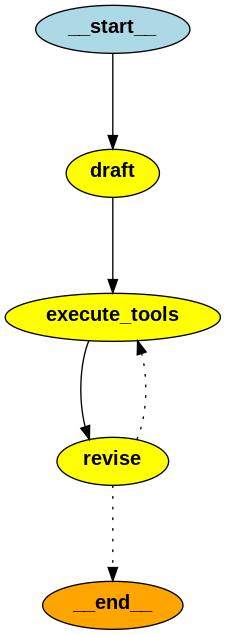

In [95]:
# plot run_graph
from IPython.display import Image

Image(run_graph.get_graph().draw_png())

In [96]:
events = run_graph.stream(
    {"messages": [HumanMessage(content=question)]},
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step["messages"][-1].pretty_print()

Step 0
================================ Human Message =================================

Why is reflection useful in AI?
Step 1
================================== Ai Message ==================================
Tool Calls:
  AnswerQuestion (call_NVBsJ5UBj9GsMRhSD626EUhB)
 Call ID: call_NVBsJ5UBj9GsMRhSD626EUhB
  Args:
    answer: Reflection is a crucial aspect of artificial intelligence (AI) because it enhances the ability of AI systems to learn from their experiences and adapt their behavior accordingly. By incorporating reflective processes, AI can analyze previous actions, evaluate their effectiveness, and adjust future strategies to improve outcomes. This is particularly significant in machine learning and reinforcement learning, where agents learn optimal behaviors through trial and error. 

Moreover, reflection can help AI systems develop a deeper understanding of complex environments and tasks. For instance, in natural language processing, reflective mechanisms allow models to rec